In [117]:
import pandas as pd
import pandas
import seaborn as sns
import pyodbc
from gensim import corpora, models, similarities
import nltk
import re
import random
import binascii
import logging, gensim, bz2
from nltk.tag import pos_tag
import logging
import re
import tempfile
import tarfile, zipfile
import numpy as np
from gensim.utils import tokenize
from collections import defaultdict
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import vertica_python

frequency = defaultdict(int)

conn_info = {'host': 'vertica04.reputation.ec2', 
             'port': 5433, 
             'user': 'rep_engine_user', 
             'password': 'r3p_3ng1n3', 
             'database': 'rwarehouse'}

cnxn = vertica_python.connect(**conn_info)

%matplotlib inline

In [119]:
## query for top 10 locations per industry
query_top10 = """
select 
industry,
score,
AVG(weighted_rating) as a_weighted_rating,
AVG(visibility) as a_visibility, 
AVG(spread) as a_spread,
AVG(volume) as a_volume,
AVG(time) as a_time, AVG(length) as a_length,
score as a_score from (
select industry, location_id, country, weighted_rating, visibility, spread, volume, time, length, score, RANK() over (
partition by industry order by score desc
) as rank 
from (
SELECT locations.industry,
mongo_repbiz_scores.score,
mongo_repbiz_scores.weighted_rating,
mongo_repbiz_scores.visibility,
mongo_repbiz_scores.spread,
mongo_repbiz_scores.volume,
mongo_repbiz_scores."time",
mongo_repbiz_scores.length,
mongo_repbiz_scores.location_id,
locations.country
FROM r4e_mongo.locations, r4e_mongo.mongo_repbiz_scores
WHERE (locations.location_id = mongo_repbiz_scores.location_id)
) as b
)
as a 
where rank <= 10
group by industry, score
order by industry asc
"""

result_top10 = pd.read_sql(query_top10, cnxn)
del result_top10['score']
del result_top10['a_score']

result_top10.loc[0] = np.array([1, 2, 3, 4, 5, 6, 7])
result_top10.columns = result_top10.iloc[0] # set column header
result_top10.loc[0] = np.array(['thermometer', 'weighted_rating', 'visibility', 'spread', 'volume', 'time', 'length'])
#result_top10

In [120]:
# query random 1000 locations from each industry, note some industries don't have that many locations
query_random1000 = """
select industry, AVG(weighted_rating) as a_weighted_rating, AVG(visibility) as a_visibility, AVG(spread) as a_spread, AVG(volume) as a_volume, AVG(time) as a_time, AVG(length) as a_length, score as a_score from (
select industry, location_id, country, weighted_rating, visibility, spread, volume, time, length, score, rank() over (
partition by industry order by random() desc
) as rank 
from
(SELECT locations.industry,
mongo_repbiz_scores.score,
mongo_repbiz_scores.weighted_rating,
mongo_repbiz_scores.visibility,
mongo_repbiz_scores.spread,
mongo_repbiz_scores.volume,
mongo_repbiz_scores."time",
mongo_repbiz_scores.length,
mongo_repbiz_scores.location_id,
locations.country
FROM r4e_mongo.locations, r4e_mongo.mongo_repbiz_scores
WHERE (locations.location_id = mongo_repbiz_scores.location_id)) as b
)
as a 
where rank <= 1000
group by industry, a_score
order by industry
"""

result_random1000 = pd.read_sql(query_random1000, cnxn)
del result_random1000['a_score']

result_random1000.loc[0] = np.array([1, 2, 3, 4, 5, 6, 7])
result_random1000.columns = result_random1000.iloc[0] # set column header
result_random1000.loc[0] = np.array(['thermometer', 'weighted_rating', 'visibility', 'spread', 'volume', 'time', 'length'])

#result_random1000

In [121]:
top10_data_industry = result_top10
top10_data_industry = top10_data_industry.transpose()
top10_data_industry.columns = top10_data_industry.iloc[0] # set column header

top10_data_industry['cat'] = "top 10" # create top/overall cat
#top10_data_industry.columns = top10_data_industry.iloc[0] # set column header
top10_data_industry.drop(top10_data_industry.head(1).index, inplace=True)
#top10_data_industry = top10_data_industry.drop(0) # drop duplicated row
#top10_data_industry = top10_data_industry.rename(columns={'industry':'thermometer'})


random_data = result_random1000
random_data = random_data.transpose()
random_data.columns = random_data.iloc[0] # set column header

random_data['cat'] = "random" # create top/overall cat
random_data.drop(random_data.head(1).index, inplace=True)

#random_data = random_data.drop("industry") # drop duplicated row
#random_data = random_data.rename(columns={'industry':'thermometer'})

#top10_data_industry

In [122]:
#random_data

automotive-automotive-other


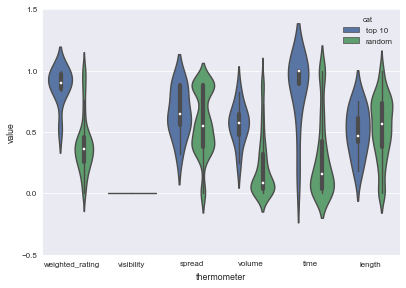

automotive-dealer


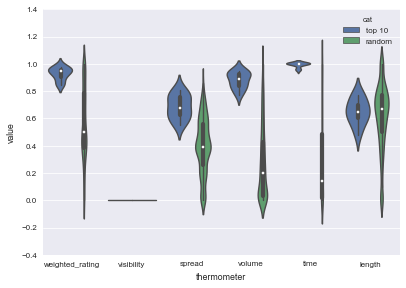

automotive-oem


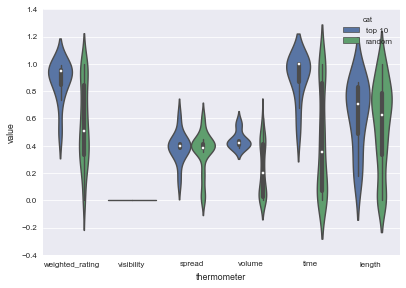

automotive-parts


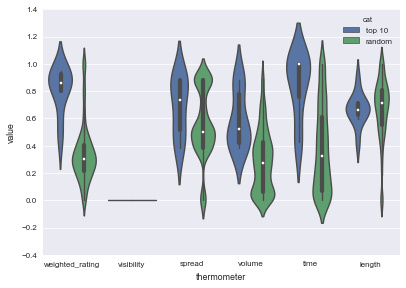

automotive-rental


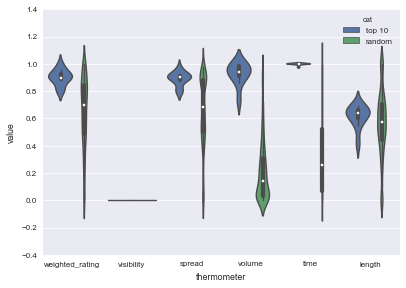

automotive-repair-&-service


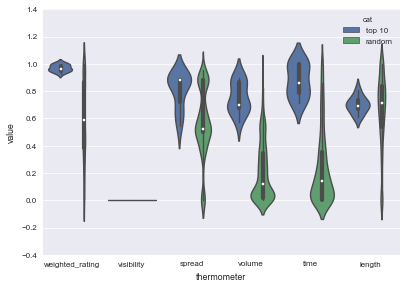

automotive-tires


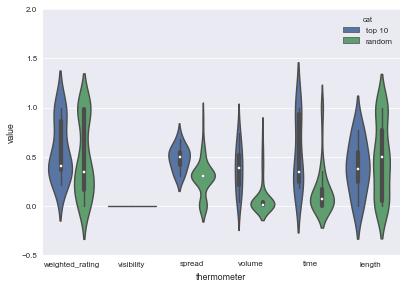

beauty-beauty-other


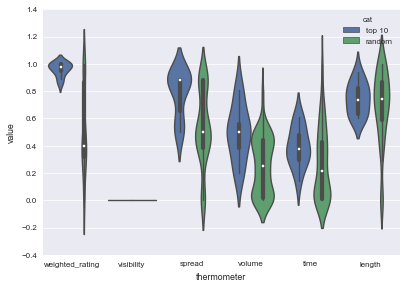

beauty-hair-grooming


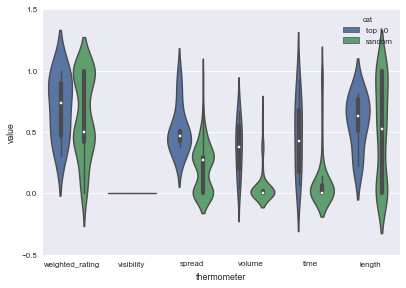

beauty-skin-care


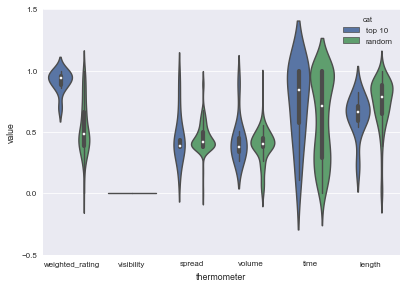

beauty-spa


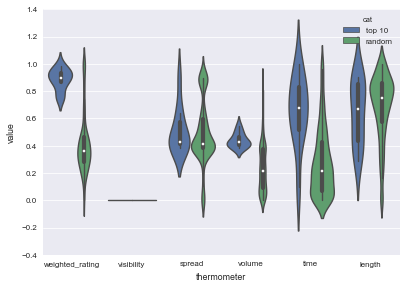

default-default


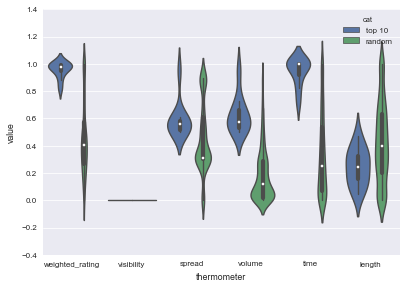

education-education-other


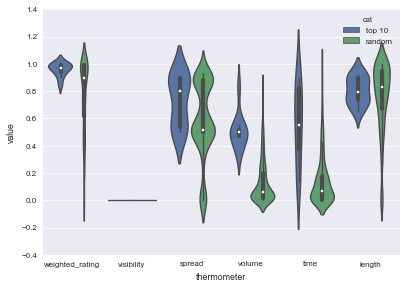

entertainment-amusement-park


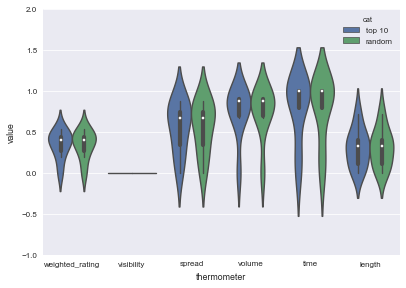

entertainment-live-performance-&-sports


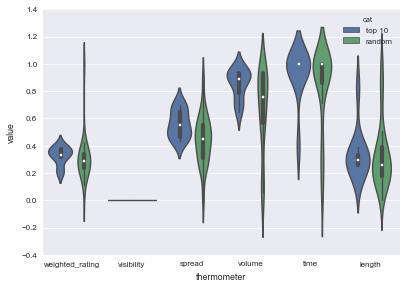

entertainment-museums-and-parks


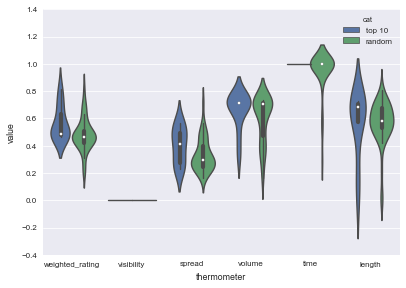

entertainment-other


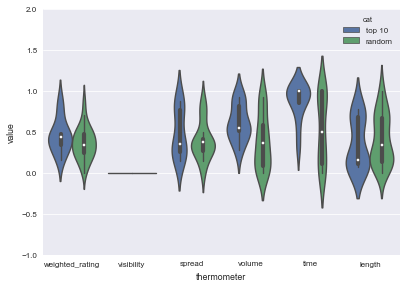

financial-services-accounting


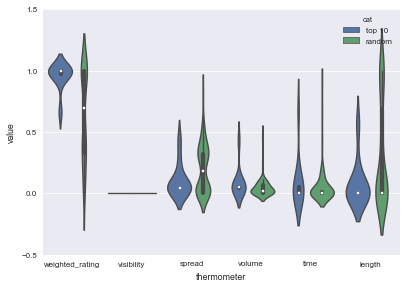

financial-services-banks


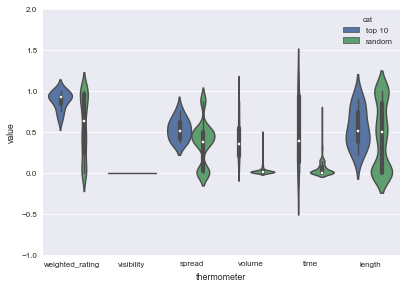

financial-services-financial-services-other


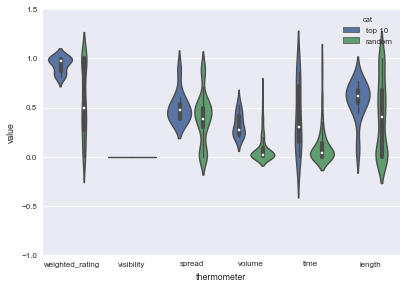

financial-services-insurance


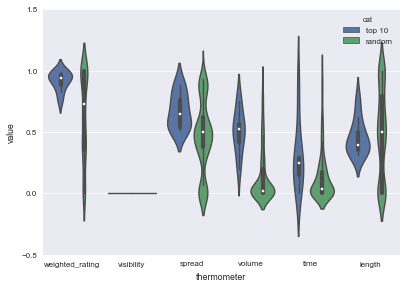

health-care-dentists


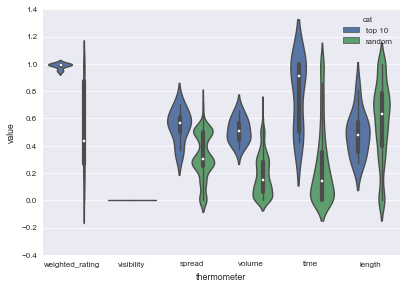

health-care-health-care-other


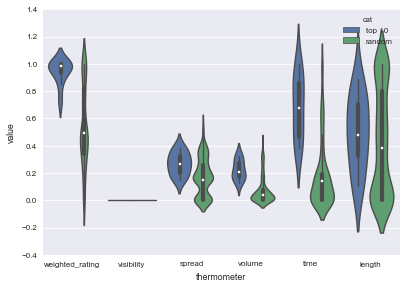

health-care-home-care


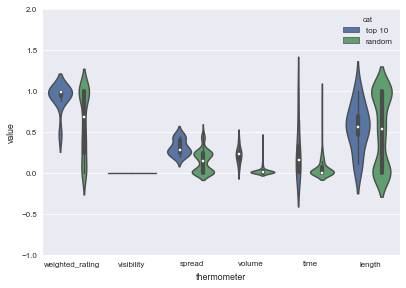

health-care-hospitals-&-facilities


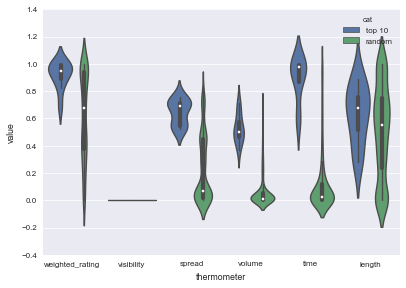

health-care-medical-spa


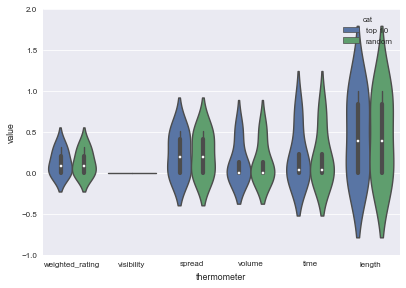

health-care-optometrist-&-opthamologist


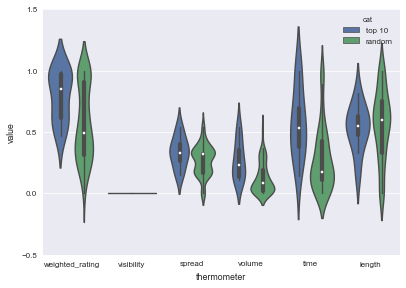

health-care-pediatricians


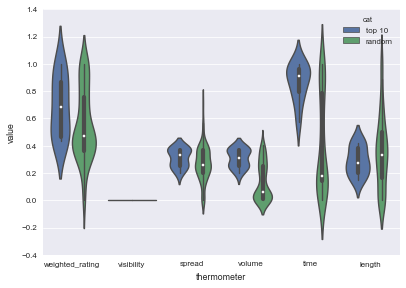

health-care-physicians


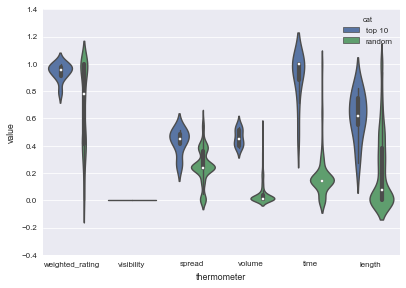

health-care-plastic-&-cosmetic-surgeons


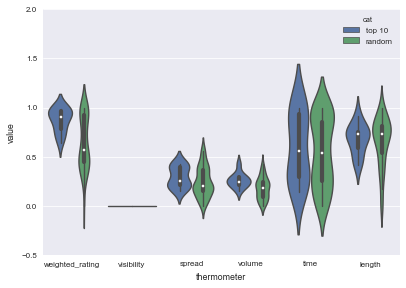

health-care-senior-care


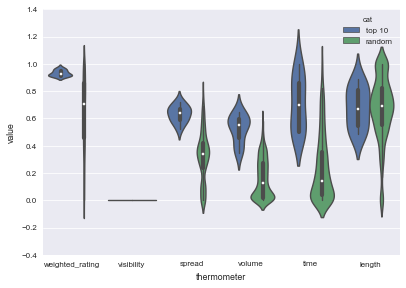

home-services-cleaning


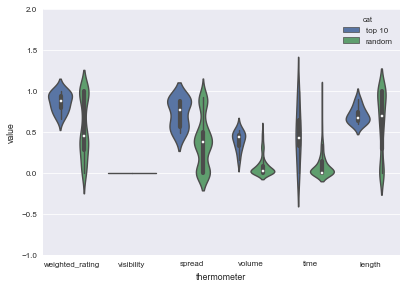

home-services-general-contracting


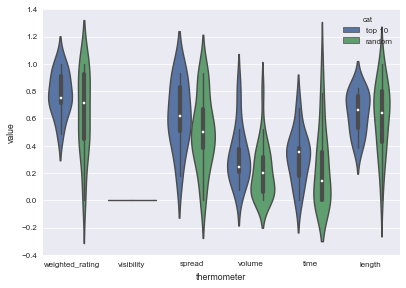

home-services-home-services-other


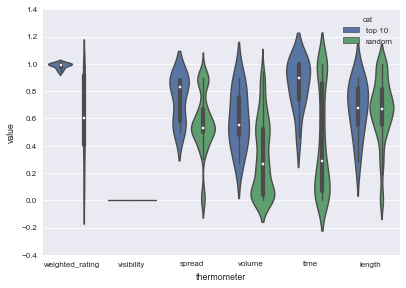

home-services-interior-design


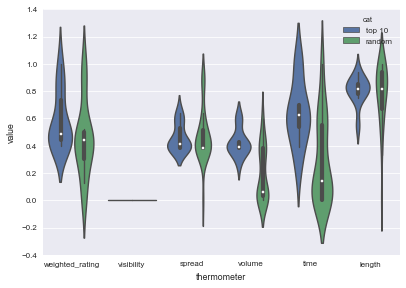

home-services-landscaping


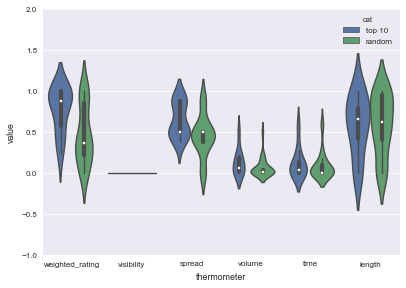

home-services-moving-&-storage


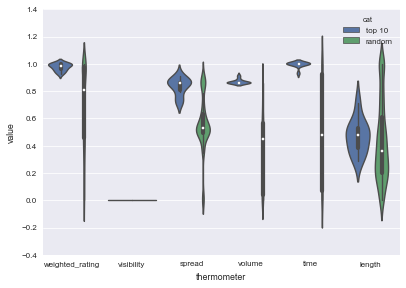

hospitality-&-travel-activities


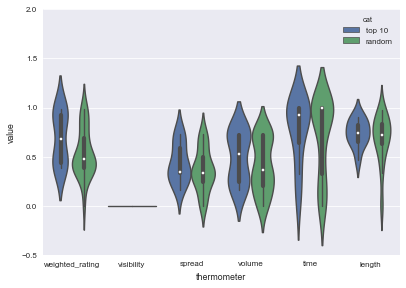

hospitality-&-travel-hospitality-&-travel-other


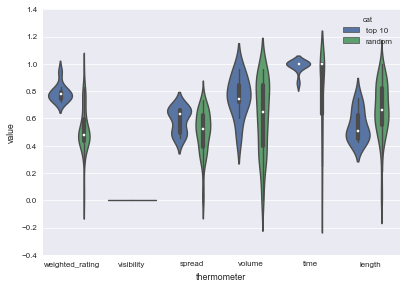

hospitality-&-travel-hotel-&-motel


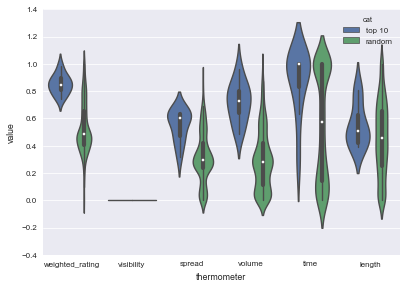

legal-law-firm


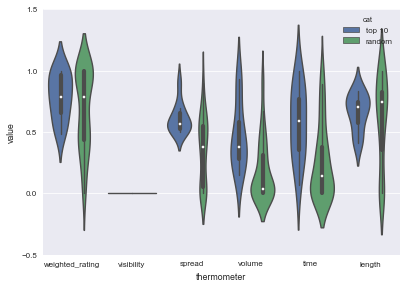

legal-legal-other


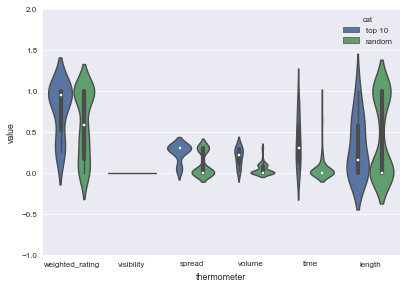

pets-pet-services


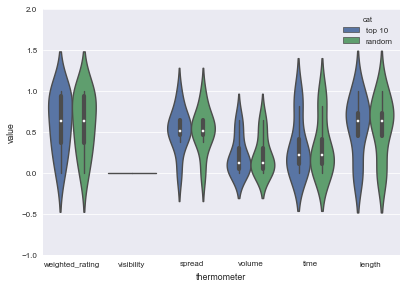

pets-pets-other


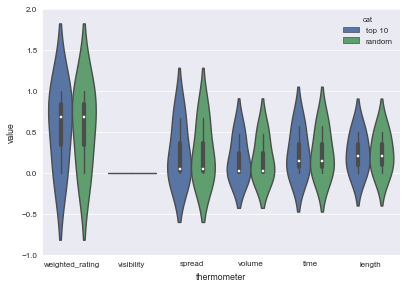

pets-veterinarians


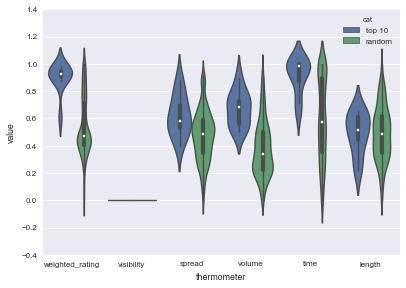

real-estate-mortgage


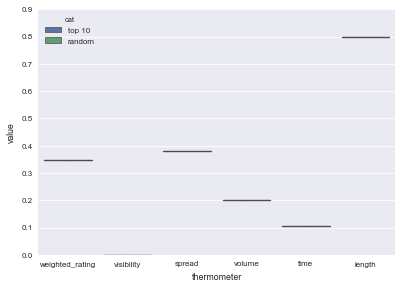

real-estate-property-management


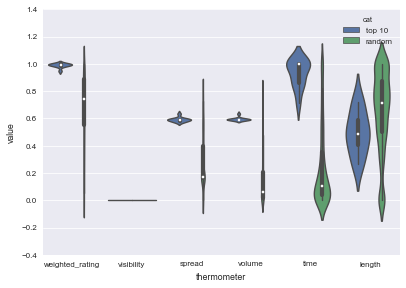

real-estate-real-estate-agency


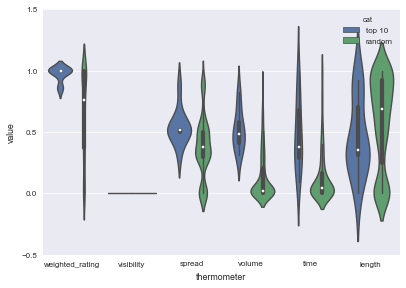

real-estate-real-estate-other


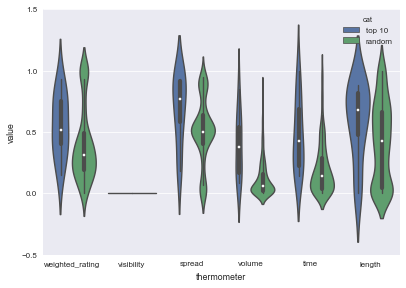

restaurants-carry-out


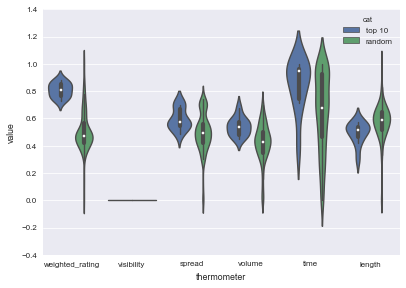

restaurants-fast-food


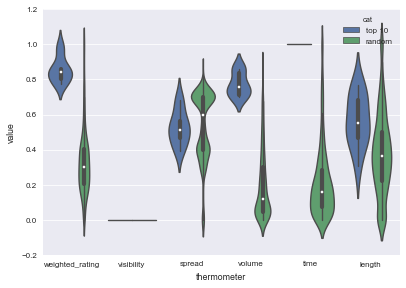

restaurants-fine-dining


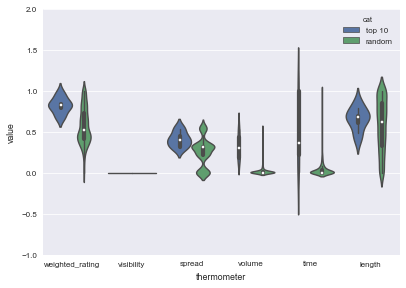

restaurants-restaurants-other


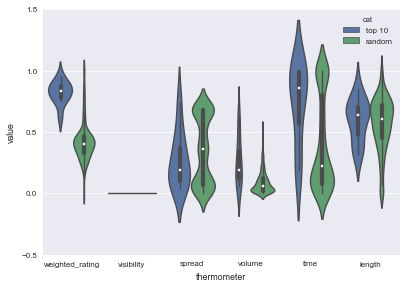

retail-big-box


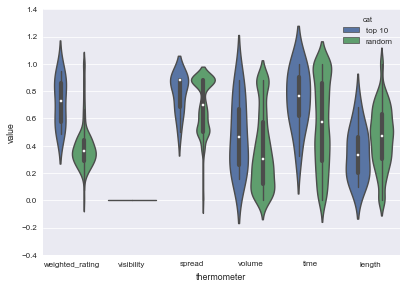

retail-department-stores


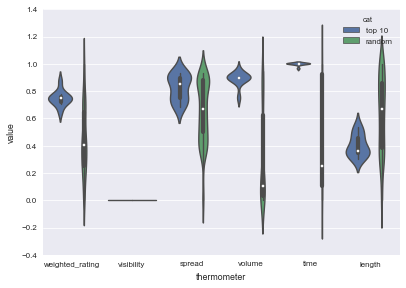

retail-retail-clothing


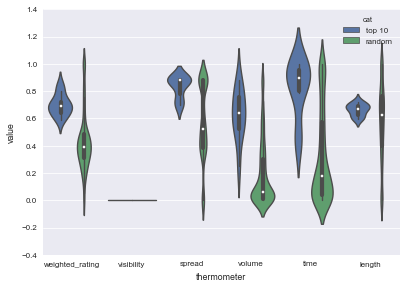

retail-retail-other


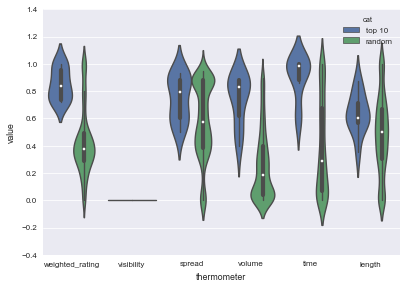

retail-special-services


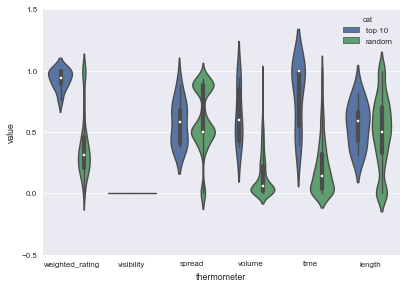

retail-supermarkets


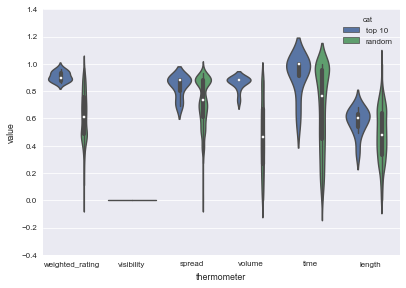

technology-electronics


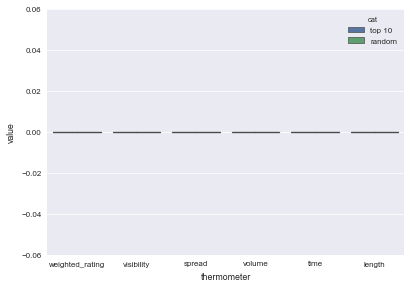

technology-internet-service-provider


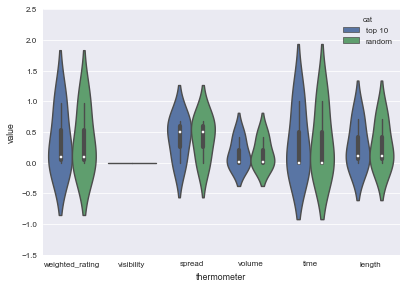

technology-mobile-provider


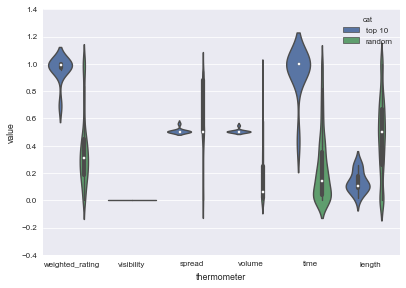

technology-technology-other


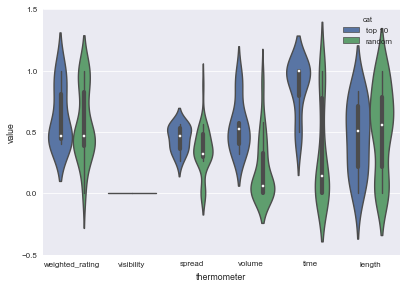

uk-take-away-food-supplier


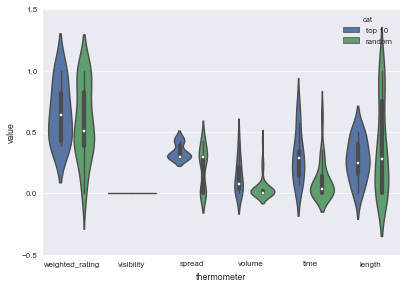

wedding-&-special-events-entertainers


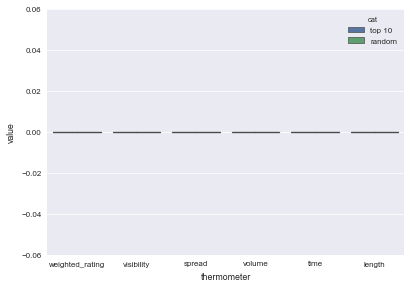

wedding-&-special-events-event-planners


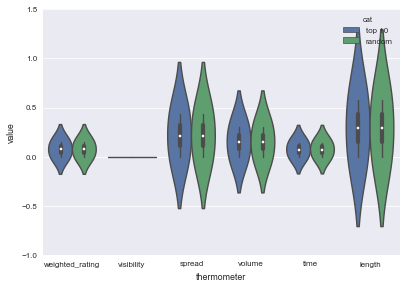

wedding-&-special-events-party-venues


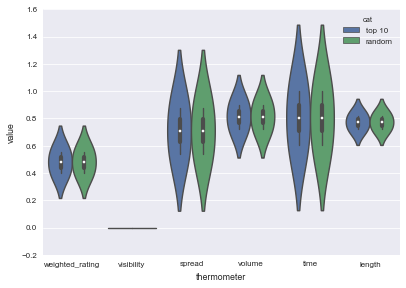

wedding-&-special-events-wedding-&-special-events-other


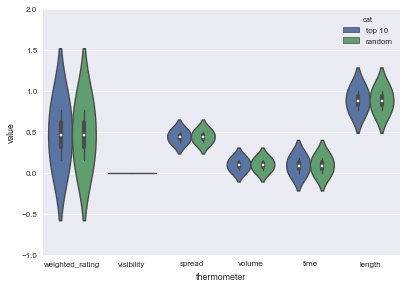

In [123]:
import matplotlib.pyplot as plt

prev = None # print unique columns

for column in top10_data_industry:
    if column != "cat" and column != "thermometer" and column != prev:
        print column
        prev = column
        temp = pd.melt(top10_data_industry, id_vars=['thermometer', 'cat'], value_vars=[column])
        temp_random = pd.melt(random_data, id_vars=['thermometer', 'cat'], value_vars=[column])
        result = temp.append(temp_random)
        result['value'] = result['value'].astype(float)
        sns.set()
        sns.set_context("paper")
        sns.violinplot(x="thermometer", y="value", hue='cat', data=result)
        plt.show()